# MSc Project Notebook

Steps of obtaining raw spectra and converting into radial velocities:
- CCD cameras record the spectral data as flux (magnitude) and wavelength


- Simulate a binary model using [SB9 Catalogue](https://heasarc.gsfc.nasa.gov/W3Browse/all/sborbitcat.html) adn fit with spectral data.
- Gaia observes a source on average 40 times, so a randomly generated array of 40 values (to replicate the 40 unique observations) is applied to the binary model.
- Gaussian filter applied, and resample the spectra to 0.025nm from 0.001nm (RVS spectra resolution is 0.025nm and we want to replicate this).
- Normalise the spectra. This is now our template spectra.
- Doppler shift each of the now normalised spectra by each of the values of the 40 observations. We now get 40 different spectra. 
- Cross correlate these new spectra with the template spectra and therefore obtain 40 cross correlation functions.

- We want to then shift the new CCF's to rest. Since we know the rest template, there is a shortcut but this idea would need to be developed for the real data cases (I think).

### Importing packages:

In [1]:
from __future__ import print_function, division
from PyAstronomy import pyasl
import numpy as np
import statistics
import matplotlib.pylab as plt
import pandas as pd
from astropy.convolution import convolve
from scipy import ndimage
import math
import spectres
np.warnings.filterwarnings('ignore') 
%run -i 'Cross Correlation Function.py'
%matplotlib inline
SEED = 42

In [2]:
data = pd.read_csv("xx03",delim_whitespace=True).rename(columns= {"sourceId": "wavelength", "57500450000": "flux"})

### Raw data: 0.001nm resolution

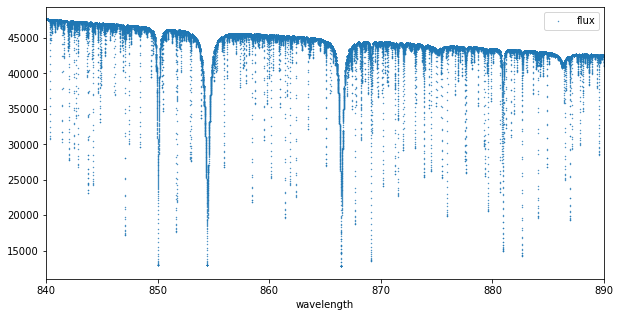

In [3]:
data.plot(style='.',x='wavelength',y='flux',ms=0.8, figsize=(10,5))
_ = plt.show()

Single Star (can only see brighter star) - shifting wrt RV implies secondary (implied SB1 as we don't see both spectral data clearly, unlike SB2)

In principle can apply this with SB2 but becomes more complicated as two templates will be moving as opposed to one, therefore simultaneous methods

Defining parameters:

In [4]:
sig_rvs = (860.5/11500.)/2.35482 

---

### IDL to Python conversion (file: normspec.pro)

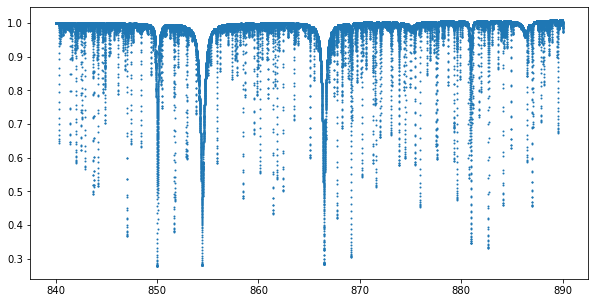

In [5]:
def norm_flux_array(data=data):
    flux_size = data.flux.size
    x1 = 25
    x2 = flux_size-1-25
    y1 = np.median(data.flux[0:51]) # first 50 data points
    y2 = np.median(data.flux[-51:-1]) # last 50 data points
    gradient = (y2-y1)/(x2-x1)
    first_flux_point = data.flux[0]

    linear_flux = np.zeros((flux_size),float)
    for i in range(0,flux_size-1):
        linear_flux[i] = first_flux_point + (gradient*i)
    norm_flux_array = data.flux/linear_flux  
    plt.figure(figsize=(10,5))
    plt.scatter(data.wavelength, norm_flux_array, s=1)
    plt.show()
    
norm_flux_array(data)

Normalising dataset:

Continuum normalisation. Approximating to original data.
- Trying to compare absorption lines relative to template. 
- If continuum is more sloped in parts than other, parts not always treated equally.

## Radial Velocity equation for Gaia's nominal mission duration:

In [6]:
def binary_model(gamma,K,P,tau):
    RV = []
    for t in np.arange(0,1825):
        v = (2*math.pi)*(t-tau)/P
        RV.append(gamma + K*np.cos(v))
    plt.figure(figsize=(20,2))
    plt.plot(RV)
    plt.xlabel('Period in Days', fontsize=14)
    plt.ylabel('Radial Velocity in km/s', fontsize=14)
    return RV
    #plt.show()
    # From SB9 catalogue. In real world, I wouldnt know this first hand

## RV for 40 random observations:

In [7]:
np.random.seed(SEED)
rand = np.random.randint(0,1825,40)

In [8]:
def Gaia_transits(gamma,K,P,tau):
    RV = []

    for t in rand:
        v = (2*math.pi)*(t-tau)/P
        RV.append(gamma + K*np.cos(v))
#     plt.figure(figsize=(20,2))
#     plt.plot(rand,RV,'s')
#     plt.xlabel('time in days', fontsize=14)
#     plt.ylabel('Radial Velocity in km/s', fontsize=14)
    return RV

Gaia_transit = Gaia_transits(0,20,40,0)

### Convolving flux with a Gaussian Line Spread Function

In [9]:
convolved_flux = ndimage.gaussian_filter1d(data.flux,sig_rvs) 

### Resampling data to Gaia RVS resolution (0.025nm):

In [10]:
wavelength = data.wavelength.to_numpy()
wavelength

array([840.   , 840.001, 840.002, ..., 889.998, 889.999, 890.   ])

In [11]:
rvs_wavelength = np.arange(840,890,0.025)
rvs_flux = spectres.spectres(rvs_wavelength,wavelength,convolved_flux)
rvs_flux = np.nan_to_num(rvs_flux, nan=47619.2)


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



Resampling new template:

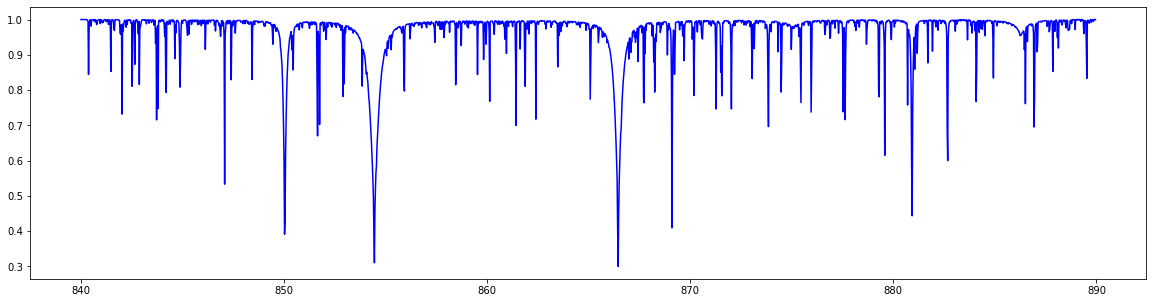

In [12]:
rvs_flux_size = rvs_flux.size
x1_rvs = 25
x2_rvs = rvs_flux_size-1-25
y1_rvs = np.median(rvs_flux[0:51])
y2_rvs = np.median(rvs_flux[-51:-1])
rvs_first_flux_point = rvs_flux[0]
gradient_rvs = (y2_rvs-y1_rvs)/(x2_rvs-x1_rvs)
linear_flux_rvs = np.zeros((rvs_flux_size),float)
for i in range(0,rvs_flux_size-1):
    linear_flux_rvs[i] = rvs_first_flux_point + (gradient_rvs)*i
    """Normalising the convolved flux"""
norm_flux_array_rvs = rvs_flux/linear_flux_rvs
plt.figure(figsize=(20,5))
plt.plot(rvs_wavelength,norm_flux_array_rvs,'b')
plt.show()

RVS wavelength range: 846-870nm:

### Doppler Shifting RVs:

In [13]:
flux = []
wlprime = []
for i in range(40):
    flux.append(pyasl.dopplerShift(rvs_wavelength, norm_flux_array_rvs,Gaia_transit[i])[0])
    wlprime.append(pyasl.dopplerShift(rvs_wavelength, norm_flux_array_rvs,Gaia_transit[i])[1])

### Doppler Shifting RVs (RVS range 846-870nm):

In [14]:
%%time
nflux_rvs = []
wlprime_rvs = []

for i in range(40):
    nflux_rvs.append(pyasl.dopplerShift(rvs_wavelength, norm_flux_array_rvs,Gaia_transit[i])[0][240:1200])
    wlprime_rvs.append(pyasl.dopplerShift(rvs_wavelength, norm_flux_array_rvs,Gaia_transit[i])[1][240:1200])

CPU times: user 8.74 ms, sys: 949 µs, total: 9.69 ms
Wall time: 8.94 ms


---

## CCFs

### Template CCF

In [15]:
rv_test, cc_test = crosscorrRV(
    rvs_wavelength[240:1200],norm_flux_array_rvs[240:1200],
    rvs_wavelength,norm_flux_array_rvs,-1000.,1000.,1.,mode='doppler',skipedge=0)

### 40 CCFs

In [16]:
%%time
rv = []
cc = []

for i in range(40):
    rv.append(crosscorrRV(wlprime_rvs[i],nflux_rvs[i],rvs_wavelength,norm_flux_array_rvs,-1000.,1000.,1.,mode='doppler',skipedge=0)[0])
    cc.append(crosscorrRV(wlprime_rvs[i],nflux_rvs[i],rvs_wavelength,norm_flux_array_rvs,-1000.,1000.,1.,mode='doppler',skipedge=0)[1])

CPU times: user 31.1 s, sys: 2.19 ms, total: 31.1 s
Wall time: 31.2 s


In [17]:
df = pd.DataFrame(data=list(zip(rv,cc)),columns=['rv','cc'])
df.to_csv('CCFs.csv')

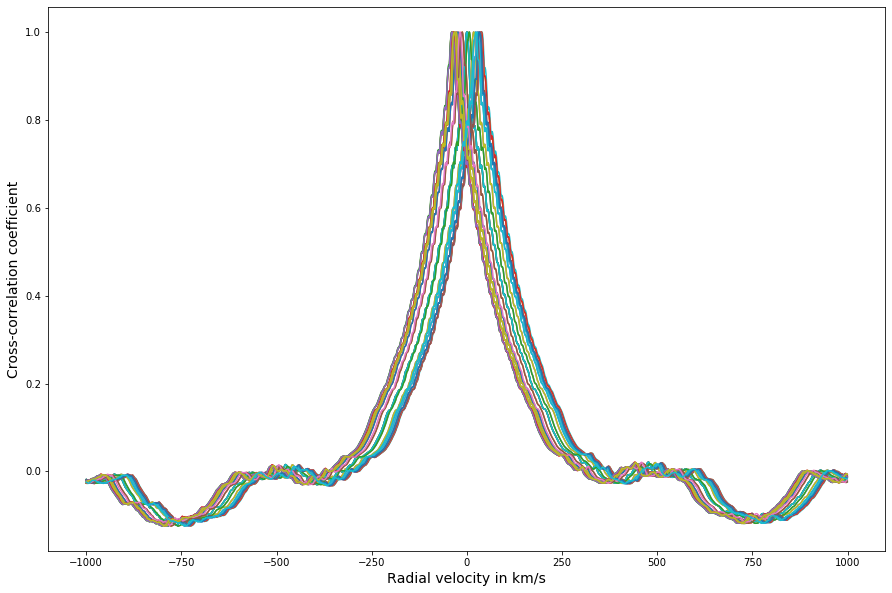

In [18]:
plt.figure(figsize=(15,10))
maxind_tem = np.argmax(cc_test)
#print("Template cross-correlation function is maximized at RV = ", rv_tem[maxind_tem], " km/s")
maxind = [np.argmax(cc[i]) for i in range(40)]

plt.plot(rv_test,cc_test,'k')
for i in range(40):
    plt.plot(rv[i],cc[i])
    #print("Cross-correlation function is maximized at RV = ", rv[i][maxind[i]], " km/s")
    plt.xlabel("Radial velocity in km/s", fontsize=14)
    plt.ylabel("Cross-correlation coefficient", fontsize=14)
    #plt.xlim(-50,50)
    
#     if rv[i][maxind[i]] > 0.0:
#         print("red-shift with respect to the template")
#     else:
#         print("blue-shift with respect to the template")
plt.show()

Note: The cross correlation works. A systematic error by a factor of 2 is present for all doppler shift km/s.

---

In [19]:
cc_test = []
for j in range(2000):
    for i in range(40):
        cc_test.append(cc[i][j])
split = [cc_test[x:x+40] for x in range(0,len(cc_test),40)]

totals = []
for i in range(len(split)):
    sums = sum(split[i])
    sums = sums/40
    totals.append(sums)

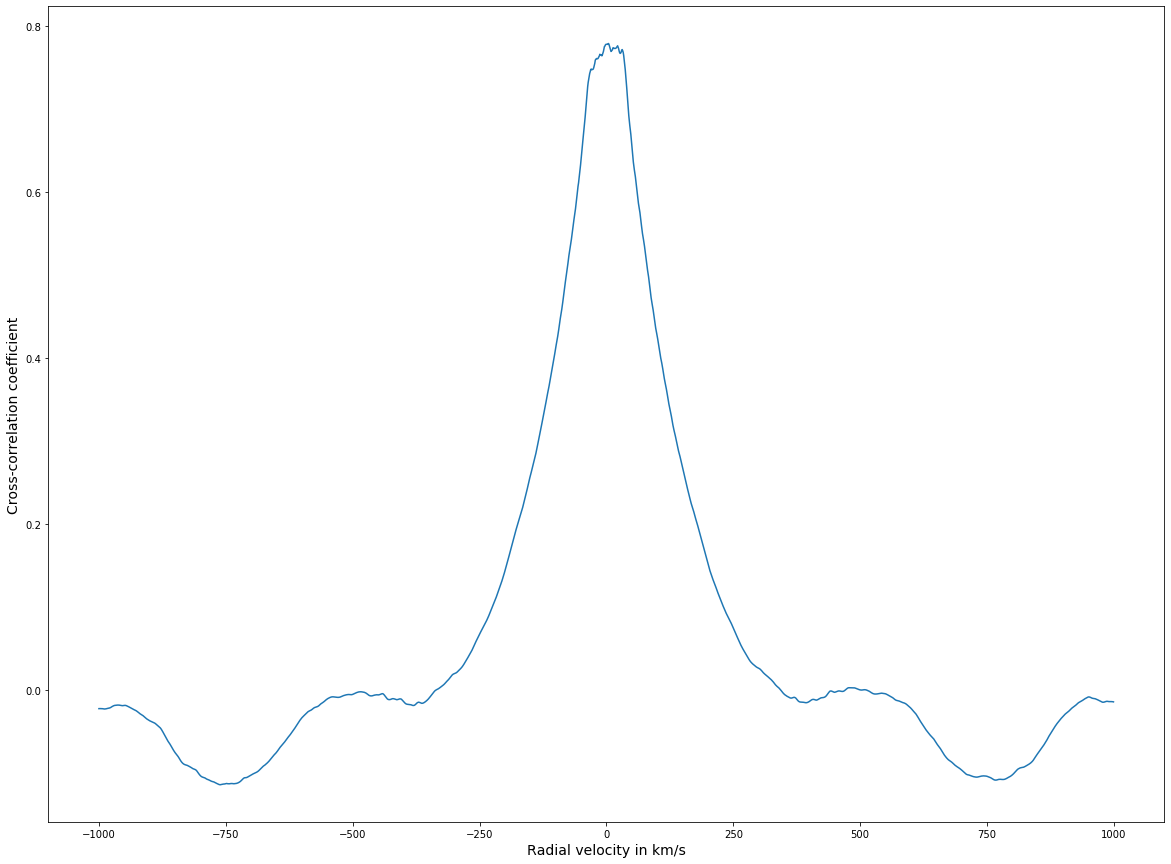

In [20]:
plt.figure(figsize=(20,15))
plt.plot(rv_test,totals)
plt.xlabel("Radial velocity in km/s",fontsize=14)
plt.ylabel("Cross-correlation coefficient",fontsize=14)
plt.show()
#Gaia DR3 illustration

### Obtaining averaged CCF

### Shifting RVs back to rest

Reversing the signs of the velocity to get the opposite:

In [21]:
def reverse_signs(lst): 
    return [ -i for i in lst ]
radvel_gaia_rev = reverse_signs(Gaia_transit)

In [22]:
%%time
back_shift_rv = []
for i in range(40):
    back_shift_rv.append(rv[i]+(radvel_gaia_rev[i]*2))


CPU times: user 531 µs, sys: 0 ns, total: 531 µs
Wall time: 402 µs


CPU times: user 51.5 ms, sys: 980 µs, total: 52.5 ms
Wall time: 51.2 ms


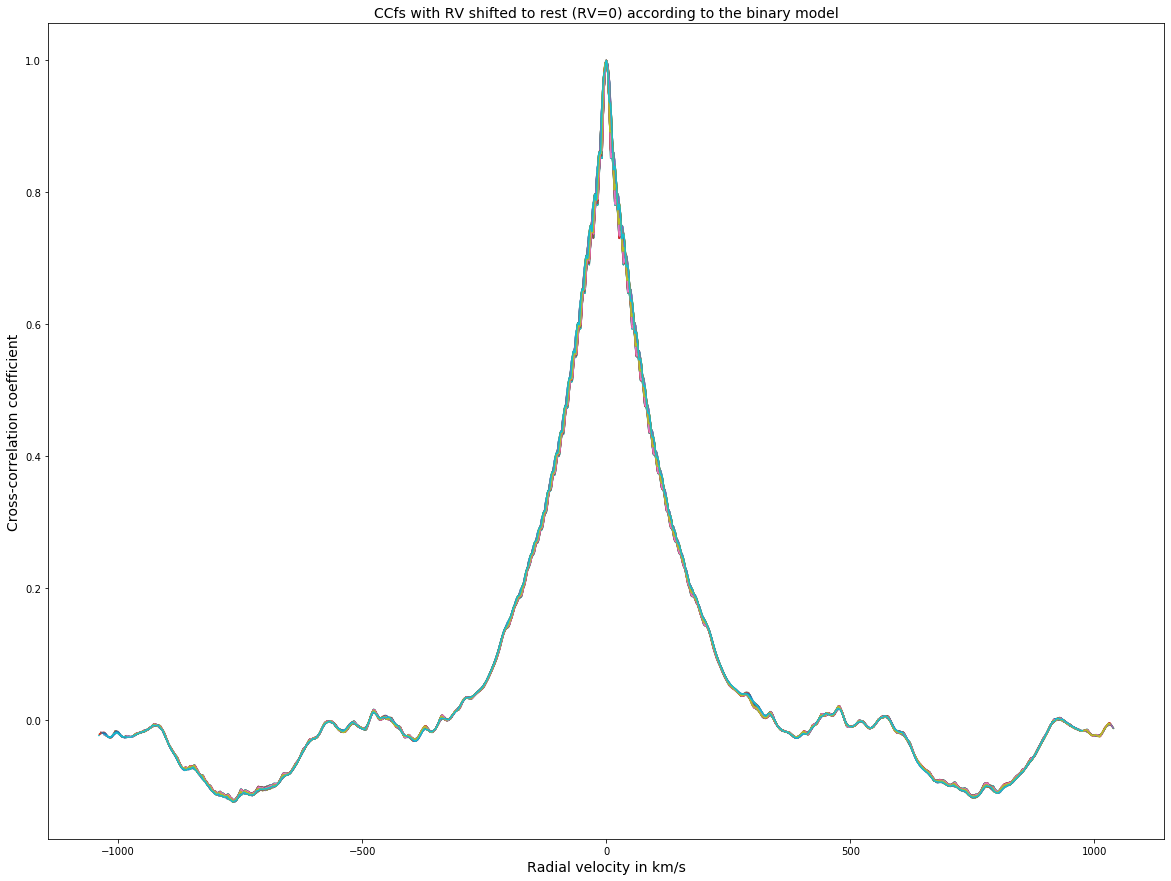

In [23]:
%%time
plt.figure(figsize=(20,15))
for i in range(40):
    plt.plot(back_shift_rv[i],cc[i])
    plt.title('CCfs with RV shifted to rest (RV=0) according to the binary model', fontsize=14)
    plt.xlabel("Radial velocity in km/s", fontsize=14)
    plt.ylabel("Cross-correlation coefficient", fontsize=14)

the reverse doppler shift is the "shortcut" instead of brute force.

In [24]:
tot_rv = np.arange(-1000,1001,1)

Resampling is used to put all the RV's on the same plot/axis and "space." therefore at each RV bin we can average each CCF.

CPU times: user 52.2 ms, sys: 6 µs, total: 52.2 ms
Wall time: 51.2 ms


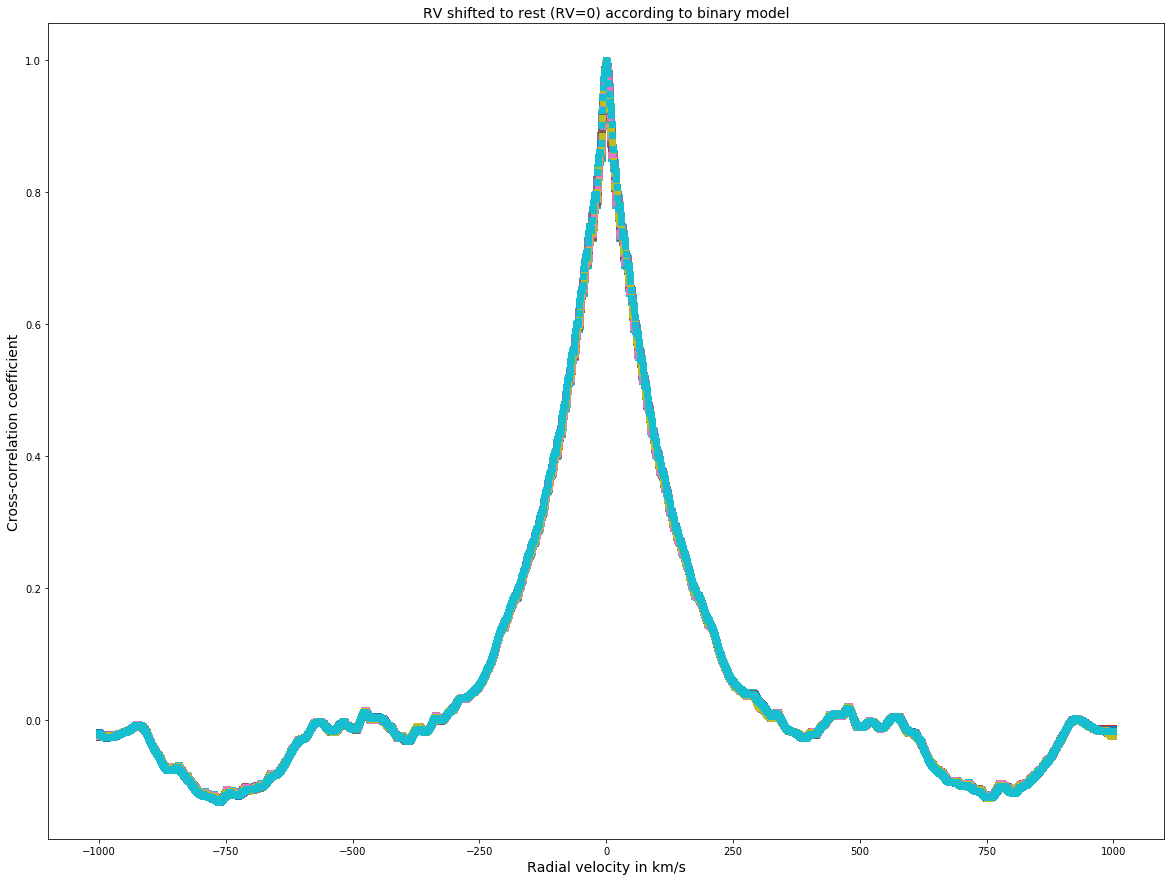

In [25]:
%%time
cc_interp = []

plt.figure(figsize=(20,15))
for i in range(40):
    cc_interp.append(np.interp(tot_rv,back_shift_rv[i],cc[i]))
    plt.plot(tot_rv,cc_interp[i],'s')
    plt.title('RV shifted to rest (RV=0) according to binary model', fontsize=14)
    plt.xlabel("Radial velocity in km/s",fontsize=14)
    plt.ylabel("Cross-correlation coefficient",fontsize=14)

---

In [26]:
%%time
cc_interp_test = [cc_interp[i][j] for j in range(2000) for i in range(40)]
split_interp = [cc_interp_test[x:x+40] for x in range(0,len(cc_interp_test),40)]

CPU times: user 9.47 ms, sys: 2 ms, total: 11.5 ms
Wall time: 11.5 ms


In [27]:
%%time
sums_new = [sum(split_interp[i]) for i in range(len(split_interp))]
totals_interp = [sums_new[i]/40 for i in range(len(split_interp))]

CPU times: user 7.63 ms, sys: 0 ns, total: 7.63 ms
Wall time: 7.63 ms


In [28]:
for i in range(40):
    curve = np.asarray(rv[i]+(radvel_gaia_rev[i]*2))
    back_shift_rv.append(curve[cc[i]==max(cc[i])])
    #max_cc.append(max(cc[i]))
    


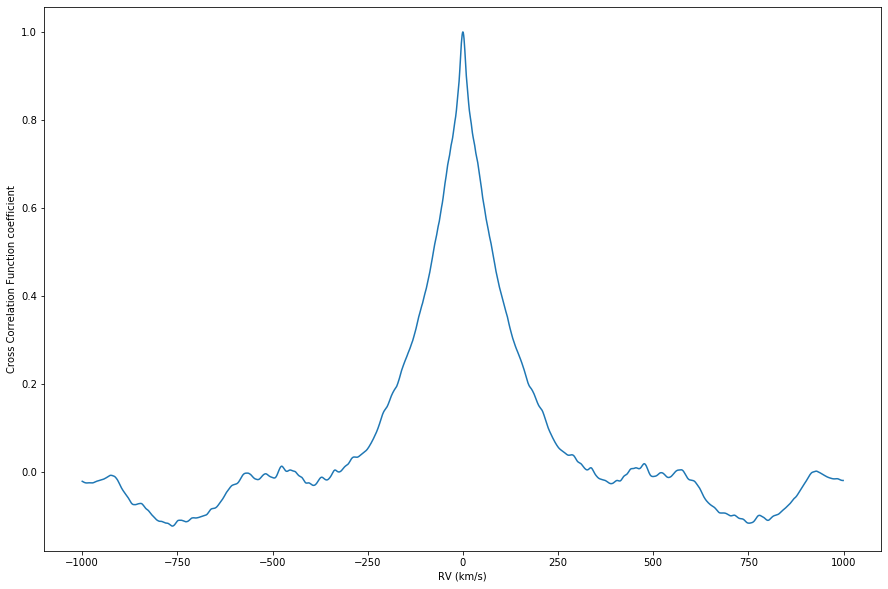

In [29]:
tot_rv_less = np.arange(-1000,1000,1)
plt.figure(figsize=(15,10))
plt.plot(tot_rv_less,totals_interp)
plt.xlabel('RV (km/s)')
plt.ylabel('Cross Correlation Function coefficient')
plt.show()

good result.

---

### Nested Sampling

In [30]:
from numpy import pi, log, sqrt
import pypolychord
from pypolychord.settings import PolyChordSettings
from pypolychord.priors import UniformPrior

### Sampling method - Position:

In [31]:
%time
nDims = 4
nDerived = 0
sigma = 0.1
theta = [0,20,40,0]
def likelihood(theta):
    gamma = theta[0]
    K = theta[1]
    P = theta[2]
    tau = theta[3]
    
    """ Obtaining RV values """
    
    RV_sample = []
    for t in rand:
        v = (2*math.pi)*(t-tau)/P
        RV_sample.append(gamma + K*np.cos(v))
        
    """ Reversing RV values for original 40 values that were just obtained """
    radvel_gaia_rev_sample = [-x for x in RV_sample]
    
    """ Shifting back the original CCF's from earlier by the RV values obtained in the previous step """
    back_shift_rv2 = []
    for i in range(40):
        curve = np.asarray(rv[i]+(radvel_gaia_rev_sample[i]*2))
        back_shift_rv2.append(curve[cc[i]==[max(cc[i])]])
    back_shift_rv2 = np.asarray(back_shift_rv2)

    
    return back_shift_rv2, []

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


In [32]:
def prior(hypercube):
    prior = []
    prior.append(UniformPrior(-10, 10)(hypercube[0])) # Gaia search region
    prior.append(UniformPrior(0, 600)(hypercube[1])) # Semi amplitude range from SB9
    prior.append(UniformPrior(0, 1000)(hypercube[2])) # Period range from SB9
    prior.append(UniformPrior(0, 1825)(hypercube[3])) # 5 year nominal mission in days
    return prior

In [33]:
def dumper(live, dead, logweights, logZ, logZerr):
    print("Last dead point:", dead[-1])

In [34]:
settings = PolyChordSettings(nDims, nDerived)
settings.file_root = 'gaussian'
settings.nlive = 50
settings.do_clustering = True
settings.read_resume = False

In [35]:
%time
output = pypolychord.run_polychord(likelihood, nDims, nDerived, settings, prior, dumper)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


TypeError: loglikelihood must be a float (element 0 of loglikelihood return)

In [36]:
paramnames = [('p%i' % i, r'\theta_%i' % i) for i in range(nDims)]
#paramnames = [('cc_coeff', 'gamma'),('cc_coeff', 'K'),('cc_coeff','p'), ('cc_coeff', 'tau')]
output.make_paramnames_files(paramnames)
paramnames

NameError: name 'output' is not defined

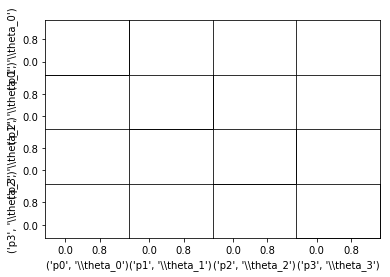

In [37]:
try:
    from anesthetic import NestedSamples
    samples = NestedSamples(root= settings.base_dir + '/' + settings.file_root)
    fig, axes = samples.plot_2d(paramnames)
    fig.savefig('posterior position.pdf')

except ImportError:
    try:
        import getdist.plots
        posterior = output.posterior
        g = getdist.plots.getSubplotPlotter()
        g.triangle_plot(posterior, filled=True)
        g.export('posterior.pdf')
    except ImportError:
        print("Install matplotlib and getdist for plotting examples")

    print("Install anesthetic or getdist  for for plotting examples")

In [38]:
#gaussian = pd.read_fwf('/users/azib/documents/msc_thesis/chains/gaussian.txt')

In [39]:
gaussian.columns = ['weights','likelihood','gamma','K','P','tau']

NameError: name 'gaussian' is not defined

In [ ]:
gaussian

In [ ]:
max_l = gaussian.loc[gaussian['likelihood'].idxmax()]
max_l

---

### Sampling method - Height:

CPU times: user 85.9 ms, sys: 1.99 ms, total: 87.8 ms
Wall time: 87.1 ms


(0.9992868977399356, [])

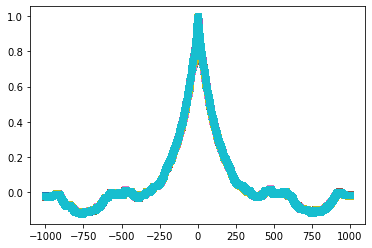

In [40]:
%%time
nDims = 4
nDerived = 0
sigma = 0.1
def sample(theta):
    gamma = theta[0]
    K = theta[1]
    P = theta[2]
    tau = theta[3]
    
    """ Obtaining RV values """
    
    RV_sample = []
    for t in rand:
        v = (2*math.pi)*(t-tau)/P
        RV_sample.append(gamma + K*np.cos(v))
        
    """ Reversing RV values for original 40 values that were just obtained """
    radvel_gaia_rev_sample = [-x for x in RV_sample]
    
    """ Shifting back the original CCF's from earlier by the RV values obtained in the previous step """
    back_shift_rv2 = [(rv[i]+(radvel_gaia_rev_sample[i]*2)) for i in range(40)]
    
    back_shift_rv2 = []
    for i in range(40):
        curve = np.asarray(rv[i]+(radvel_gaia_rev_sample[i]*2))
        back_shift_rv2.append(curve[cc[i]==max(cc[i])])
    back_shift_rv2 = np.asarray(back_shift_rv2)

    """ resmapling onto a new template from -1000 to 1000 in steps of 1km/s """
    tot_rv = np.arange(-1000,1000,1)
    
    cc_interp = []
    for i in range(40):
        cc_interp.append(np.interp(tot_rv,back_shift_rv[i],cc[i]))
        plt.plot(tot_rv,cc_interp[i],'s')

    """ splitting the sample into batches of 40 to be able to perform the next step """

    cc_interp_test = [cc_interp[i][j] for j in range(2000) for i in range(40)]
    split_interp = [cc_interp_test[x:x+40] for x in range(0,len(cc_interp_test),40)]
            
    """ taking each index of the 40 values and performing averaging calculations """
        
    sums_new = [sum(split_interp[i]) for i in range(len(split_interp))]
    totals_interp = [sums_new[i]/40 for i in range(len(split_interp))]
    totals_interp_asarray = np.asarray(totals_interp)
    
  
    return max(totals_interp_asarray)**2, []
theta = [0,20,40,0]
sample(theta)

In [41]:
def prior(hypercube):
    prior = []
    prior.append(UniformPrior(-100, 100)(hypercube[0])) # Gaia search region
    prior.append(UniformPrior(0, 600)(hypercube[1])) # Semi amplitude range from SB9
    prior.append(UniformPrior(0, 1000)(hypercube[2])) # Period range from SB9
    prior.append(UniformPrior(0, 1825)(hypercube[3])) # 5 year nominal mission in days
    return prior

In [42]:
def dumper(live, dead, logweights, logZ, logZerr):
    print("Last dead point:", dead[-1])

In [43]:
settings_height = PolyChordSettings(nDims, nDerived)
settings_height.file_root = 'gaussian height'
settings_height.nlive = 50
settings_height.do_clustering = True
settings_height.read_resume = False

In [ ]:
%time
output = pypolychord.run_polychord(sample, nDims, nDerived, settings_height, prior, dumper)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


In [ ]:
paramnames = [('p%i' % i, r'\theta_%i' % i) for i in range(nDims)]
#paramnames = [('cc_coeff', '\\gamma'),('cc_coeff', '\\K'),('cc_coeff','\\p'), ('cc_coeff', '\\tau')]
output.make_paramnames_files(paramnames)

In [ ]:
try:
    from anesthetic import NestedSamples
    samples = NestedSamples(root= settings_height.base_dir + '/' + settings_height.file_root)
    fig, axes = samples.plot_2d(['p0','p1','p2','p3'])
    fig.savefig('posterior height.pdf')

except ImportError:
    try:
        import getdist.plots
        posterior = output.posterior
        g = getdist.plots.getSubplotPlotter()
        g.triangle_plot(posterior, filled=True)
        g.export('posterior.pdf')
    except ImportError:
        print("Install matplotlib and getdist for plotting examples")

    print("Install anesthetic or getdist  for for plotting examples")